In [ ]:
!pip install numpy
!pip install d2l --no-deps

In [ ]:
from google.colab import files

# This will open a 'Choose Files' button in your output cell
# Choose train_helpers.py
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
import time
import torch
from torch import nn
from d2l import torch as d2l
from train_helpers import train_and_eval

In [ ]:
import torch
from torch import nn
import numpy as np
import random
import os
from torch.nn import functional as F

def set_pytorch_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_pytorch_seed()

In [ ]:
accuracies = {}
training_times = {}
parameter_count = {}

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b4(self):
      return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                          Inception(160, (112, 224), (24, 64), 64),
                          Inception(128, (128, 256), (24, 64), 64),
                          Inception(112, (144, 288), (32, 64), 64),
                          Inception(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    def __init__(self, lr=0.1, num_classes=10):
      super(GoogleNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                              self.b5(), nn.LazyLinear(num_classes))
      self.net.apply(d2l.init_cnn)

In [ ]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

In [ ]:
train_and_eval(model, d2l.FashionMNIST(batch_size=128, resize=(96, 96)))

## Batch Normalization

In [ ]:
class InceptionBN(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(c1)

        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(c2[0])
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1, bias=False)
        self.bn2_2 = nn.BatchNorm2d(c2[1])

        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(c3[0])
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2, bias=False)
        self.bn3_2 = nn.BatchNorm2d(c3[1])

        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1, bias=False)
        self.bn4_2 = nn.BatchNorm2d(c4)

    def forward(self, x):
        # Branch 1: Conv -> BN -> ReLU
        b1 = F.relu(self.bn1_1(self.b1_1(x)))

        # Branch 2: (Conv -> BN -> ReLU) -> (Conv -> BN -> ReLU)
        b2 = F.relu(self.bn2_2(self.b2_2(F.relu(self.bn2_1(self.b2_1(x))))))

        # Branch 3: (Conv -> BN -> ReLU) -> (Conv -> BN -> ReLU)
        b3 = F.relu(self.bn3_2(self.b3_2(F.relu(self.bn3_1(self.b3_1(x))))))

        # Branch 4: Pool -> Conv -> BN -> ReLU
        b4 = F.relu(self.bn4_2(self.b4_2(self.b4_1(x))))

        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:
class GoogleNetBN(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64), # Added BN
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64), # Added BN
            nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192), # Added BN
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b3(self):
        return nn.Sequential(InceptionBN(64, (96, 128), (16, 32), 32),
                            InceptionBN(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b4(self):
        return nn.Sequential(InceptionBN(192, (96, 208), (16, 48), 64),
                          InceptionBN(160, (112, 224), (24, 64), 64),
                          InceptionBN(128, (128, 256), (24, 64), 64),
                          InceptionBN(112, (144, 288), (32, 64), 64),
                          InceptionBN(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b5(self):
        return nn.Sequential(InceptionBN(256, (160, 320), (32, 128), 128),
                            InceptionBN(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

    def __init__(self, lr=0.1, num_classes=10):
        super(GoogleNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

## Inception Block Adjustments

Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the Inception architecture for computer vision. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 2818–2826).

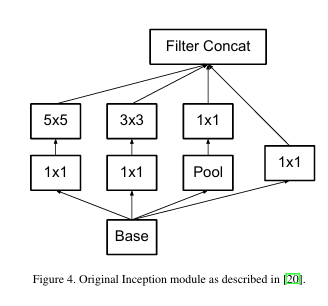

In [ ]:
class GoogleNetInception(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b3(self, Incblock):
        return nn.Sequential(Incblock(64, (96, 128), (16, 32), 32),
                            Incblock(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b4(self, Incblock):
      return nn.Sequential(Incblock(192, (96, 208), (16, 48), 64),
                          Incblock(160, (112, 224), (24, 64), 64),
                          Incblock(128, (128, 256), (24, 64), 64),
                          Incblock(112, (144, 288), (32, 64), 64),
                          Incblock(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self, Incblock):
        return nn.Sequential(Incblock(256, (160, 320), (32, 128), 128),
                            Incblock(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    def __init__(self, lr=0.1, num_classes=10, Incblock=Inception):
      super(GoogleNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1(), self.b2(), self.b3(Incblock), self.b4(Incblock),
                              self.b5(Incblock), nn.LazyLinear(num_classes))
      self.net.apply(d2l.init_cnn)

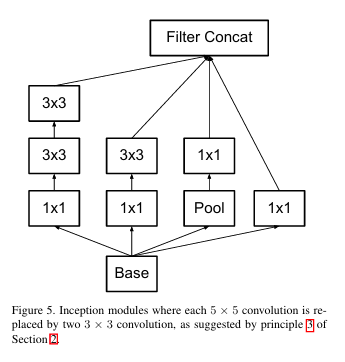

In [ ]:
class Inceptionv2(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (4th on image)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2 (1st on image)
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.b2_3 = nn.LazyConv2d(c2[2], kernel_size=3, padding=1)
        # Branch 3 (2nd on image)
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=3, padding=1)
        # Branch 4 (3rd on image)
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_3(F.relu(self.b3_2(F.relu(self.b3_1(x))))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

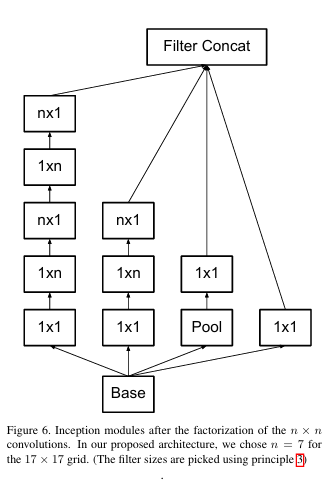

In [ ]:
class Inceptionv3(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        n=7
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (4th on image)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2 (1st on image)
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=(1,n), padding=(0,n//2))
        self.b2_3 = nn.LazyConv2d(c2[1], kernel_size=(n,1), padding=(n//2,0))
        self.b2_4 = nn.LazyConv2d(c2[1], kernel_size=(1,n), padding=(0,n//2))
        self.b2_5 = nn.LazyConv2d(c2[1], kernel_size=(n,1), padding=(n//2,0))
        # Branch 3 (2nd on image)
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=(n,1), padding=(n//2,0))
        self.b3_3 = nn.LazyConv2d(c3[2], kernel_size=(1,n), padding=(0,n//2))
        # Branch 4 (3rd on image)
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_3(F.relu(self.b3_2(F.relu(self.b3_1(x))))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

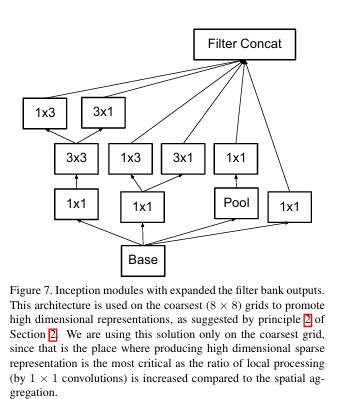

In [ ]:
class Inceptionv4(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (4th on image)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2 (1st on image)
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.b2_3 = nn.LazyConv2d(c2[2], kernel_size=(1,3), padding=(0,1))
        self.b2_4 = nn.LazyConv2d(c2[2], kernel_size=(3,1), padding=(1,0))
        # Branch 3 (2nd on image)
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=(1,3), padding=(0,1))
        self.b3_3 = nn.LazyConv2d(c3[2], kernel_size=(3,1), padding=(1,0))
        # Branch 4 (3rd on image)
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b2_1 = F.relu(self.b2_3(b2))
        b2_2 = F.relu(self.b2_4(b2))
        b3 = F.relu(self.b3_1(x))
        b3_1 = F.relu(self.b3_2(b3))
        b3_2 = F.relu(self.b3_3(b3))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2_1, b2_2, b3_1, b3_2, b4), dim=1)

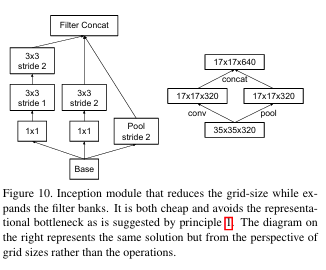

In [ ]:
class Inceptionv5(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.b1_2 = nn.LazyConv2d(c1, kernel_size=3, padding=1)
        self.b1_3 = nn.LazyConv2d(c1, kernel_size=3, padding=1, stride=2)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1, stride=2)
        # Branch 3
        self.b3_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        b1 = F.relu(self.b1_3(F.relu(self.b1_2(F.relu(self.b1_1(x))))))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_1(x))
        return torch.cat((b1, b2, b3), dim=1)

## Residual Connection

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        # Residual Branch
        self.res = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)